# Length binned gradient boosting classifier

## 1. Run setup

In [1]:
# Change working directory to parent so we can import as we would from main.py
print(f'Working directory: ', end = '')
%cd ..

from scipy.stats import uniform, randint
from sklearn.metrics import make_scorer

import configuration as config
import functions.notebook_helper as helper_funcs
import functions.notebook_plotting as plot_funcs
import functions.parallel_xgboost as xgb_funcs

Working directory: /mnt/arkk/llm_detector/classifier


Get ready to read the input data:

In [2]:
# The dataset we want to bin - omit the file extension, it will be 
# added appropriately for the input and output files
dataset_name = 'falcon-7b_scores_v2_10-300_words'

# Input file path
input_file = f'{config.DATA_PATH}/{dataset_name}.h5'

Let's also make a data structure to collect results for plotting as we go.

In [3]:
# Dictionary to hold testing/experimentation results
parsed_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

# Plots to draw
plots = ['Accuracy (%)', 'False positive rate', 'False negative rate', 'Binary cross-entropy']

Make a dictionary of scoring functions to be used as metrics:

In [4]:
# Make evaluation metrics scorers
scoring_funcs = {
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

# Number of folds to run for cross validation
cv_folds = 5
workers = 3
threads_per_worker = 6

## 2. Baseline performance
### 2.1. Cross-validation

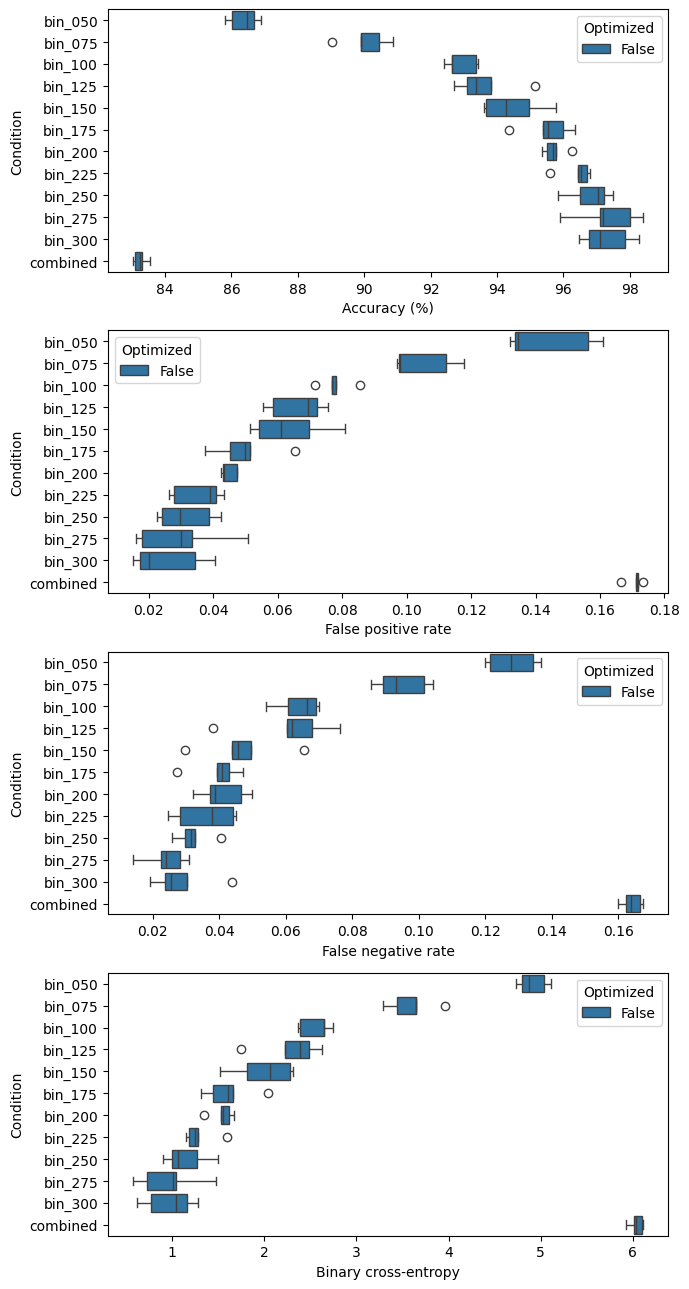

In [5]:
parsed_results = xgb_funcs.cross_validate_bins(
    input_file = input_file, 
    scoring_funcs = scoring_funcs, 
    parsed_results = parsed_results,
    cv_folds = cv_folds,
    num_workers = workers,
    threads_per_worker = threads_per_worker
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

### 2.2. Cross-validation: shuffled control

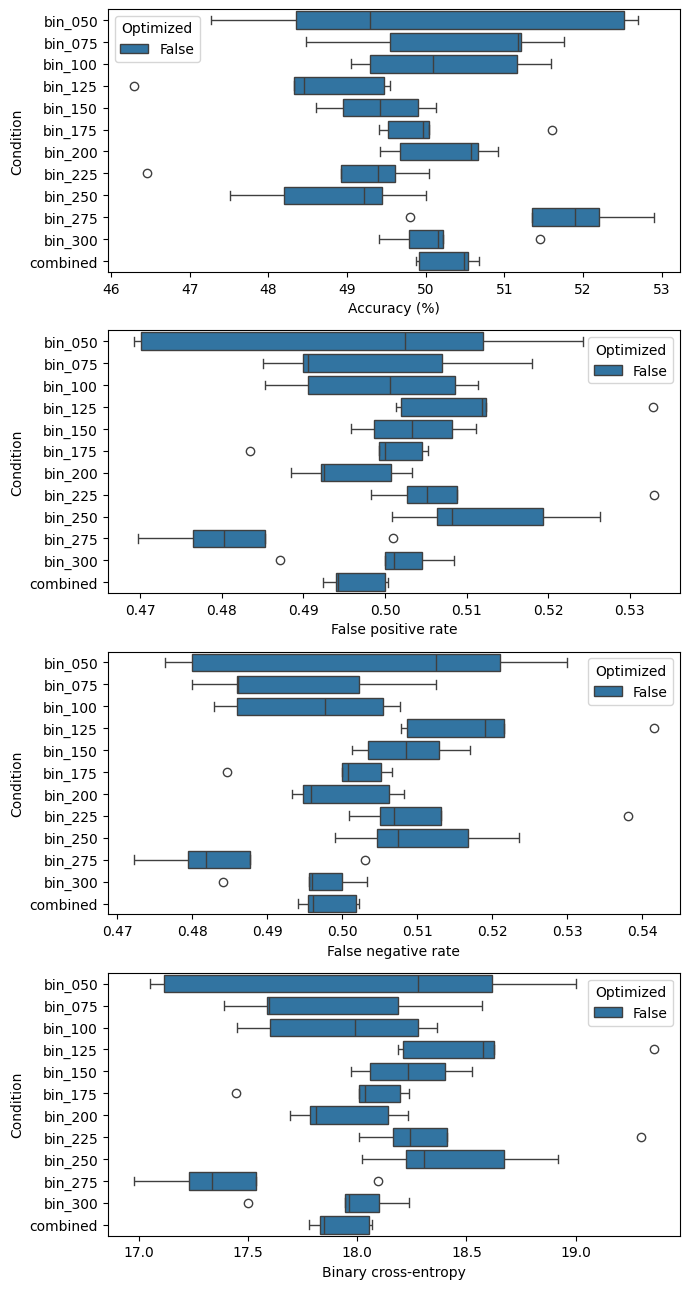

In [6]:
# Start a fresh results dictionary so we don't over-write our baseline results
parsed_control_results = {
    'Fold': [],
    'Condition': [],
    'Optimized': [],
    'Accuracy (%)': [],
    'False positive rate': [],
    'False negative rate': [],
    'Binary cross-entropy': []
}

parsed_control_results = xgb_funcs.cross_validate_bins(
    input_file = input_file, 
    scoring_funcs = scoring_funcs, 
    parsed_results = parsed_control_results,
    cv_folds = cv_folds,
    num_workers = 5, 
    shuffle_control = True
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_control_results).show()

OK, cool! That works great - the real classifier is definitely performing better than the shuffled control. Lots of things to say here, so I'll make a list:

1. The performance in the longer bins is impressive - we get to and well above 95% accuracy with no tuning or hyperparameter optimization at all.
2. Performance on short text fragments is not great in comparison. We don't get to 90% accuracy until bin 75 which contains fragments between 26 and 75 words. One of the things I know people would want to use this for is spotting bot posts on social media. But i'm starting to think content moderation is a totally different problem all together.
3. We may be leaving some accuracy on the table - remember, the bins overlap so each fragment is seen by two different classifiers. E.g. a 30 word fragment is scored by the classifiers for bins 50 and 75. Next step should probably be to combine the outputs to come up with the final classification.
4. At this point I think we might benefit from more data - some of these bins have only a few hundred or a few thousand fragments in them. Unfortunately, the bins we are performing best on are the ones with the least data, but still...
5. Cross-validation is smoking fast - using multiprocessing to parallelize over the bins and then a joblib context with a threading backend to give scikit-learn control over parallelism in the workers works great. Thought that was going to be a harder problem than it was.

Stick with it, we are almost there. I swear all of this will be worth it in the end. Next, we need to do two things:

1. Tune hyperparameters in each bin, saving the classifier for each after it has been trained using all of the training data with the winning parameters.
2. Figure out how to combine the class probabilities coming from each bin into a single prediction.

To help with thinking about that last point, let's draw a diagram for the first two bins:

```text

Fragment length (words): 1    5    10   15   25   30   35   40   45   50   55   60   65   70   75  80    85   90   95   100  105
                         +----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+----+
                 bin 50: |1                                         50|                        |                        |
                         +--------------------------------------------+                        |                        |
                 bin 75:                      |26                                            75|                        |
                                              +------------------------------------------------+                        |
                bin 100:                                               |51                                           100|
                                                                       +------------------------------------------------+
```

OK, cool, that helped. So ignoring the start and end of the range where we will have some fragments that are only scored by one classifier, the solution is easy, the 'second stage' classifier is a second set of models each take a length range equal to each overlap between the bins. So for example, here's how it would work for a fragment of length 36 looking at the above diagram.

1. Fragment gets scored by first stage bin 50 classifier.
2. Fragment gets scored by first stage bin 75 classifier.
3. Score from each classifier becomes new feature, maybe 'short score' and 'long score' or something similar.
4. Dual scored fragment is sent to a second stage '26-50' classifier that takes all of the features, including the short and long scores from the first stage classifiers, to predict a final class probability. Bang. Done.

Only other edge cases are fragments that are below 26 words or above 275 words. These are only scored by the first stage classifier for their bin and that class probability is used to make the call. For production, we can send a warning about short fragments with the prediction and for 'too long' fragments we can split and/or sample, something like that. Easy.

## 3. Hyperparameter tuning
### 3.1. Random search with cross-validation

In [7]:
# Define hyperparameter distributions for randomized grid search
parameter_distributions = {
    'learning_rate': uniform(loc = 0.001, scale = 0.999),
    'gamma': uniform(loc = 0.0, scale = 1.0),
    'max_depth': randint(1, 200),
    'min_child_weight': uniform(loc = 0.0001, scale = 0.9999),
    'subsample': uniform(loc = 0.5, scale = 0.5),
    'reg_alpha': uniform(loc = 0.0, scale = 1.0),
    'reg_lambda': uniform(loc = 0.0, scale = 1.0),
    'n_estimators': randint(1, 200),
    'num_parallel_tree': randint(1, 10)
}

# Redefine the scoring functions, this time including negated binary
# cross-entropy so that when RandomizedSearchCV try to maximize it, it's
# doing the right thing.
scoring_funcs = {
    'negated_binary_cross_entropy': make_scorer(helper_funcs.negated_binary_cross_entropy),
    'binary_cross_entropy': make_scorer(helper_funcs.binary_cross_entropy), 
    'accuracy': make_scorer(helper_funcs.percent_accuracy),
    'false_positive_rate': make_scorer(helper_funcs.false_positive_rate),
    'false_negative_rate': make_scorer(helper_funcs.false_negative_rate)
}

n_iterations = 300

# Do the optimization
results = xgb_funcs.hyperparameter_tune_bins(
    input_file, 
    parameter_distributions, 
    scoring_funcs,
    cv_folds,
    n_iterations, 
    workers, 
    threads_per_worker
)

### 3.2. Hyperparameter optimization results results

In [8]:
# Parse the results
winners, cv_results = xgb_funcs.parse_hyperparameter_tuning_results(results)

bin_050 best score: -4.3442604500633095
bin_075 best score: -3.329800399242366
bin_100 best score: -2.3640417859247482
bin_125 best score: -1.9695613122102222
bin_150 best score: -1.7565103166735767
bin_175 best score: -1.425858598489292
bin_200 best score: -1.3508898285141755
bin_225 best score: -1.1218792331614882
bin_250 best score: -1.011156049248076
bin_275 best score: -0.8145001482442638
bin_300 best score: -0.8126242650502059
combined best score: -5.766314586491364


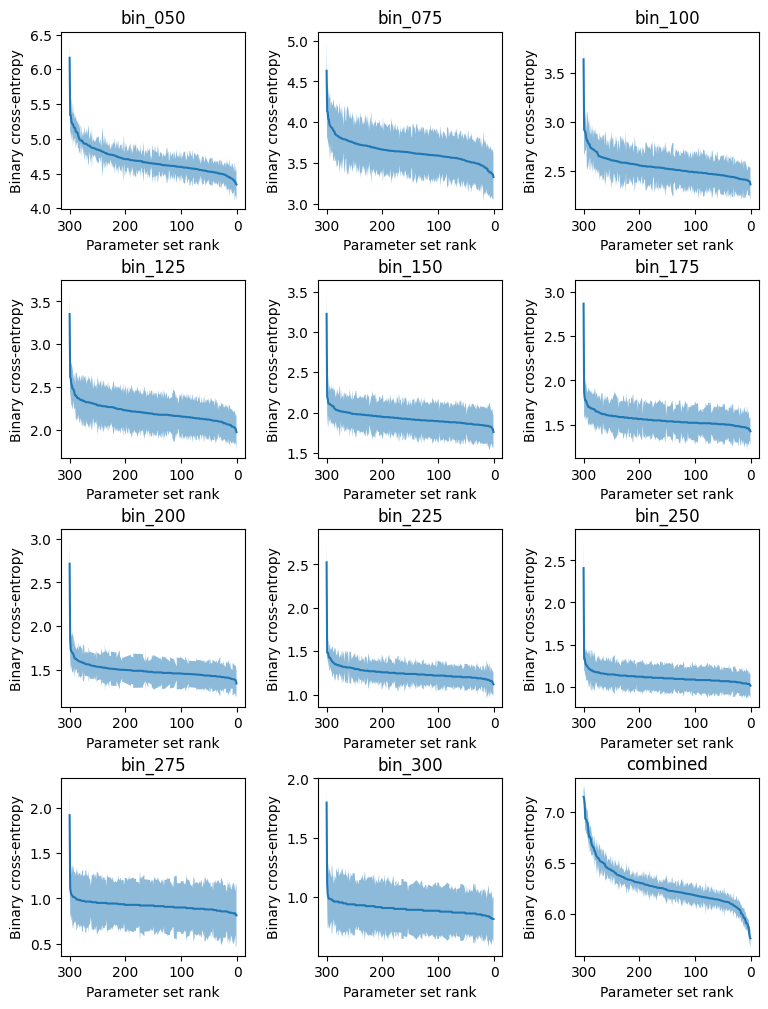

In [9]:
# Plot the results
plot_funcs.plot_hyperparameter_tuning(cv_results).show()

### 3.3. Winning models comparison to baseline

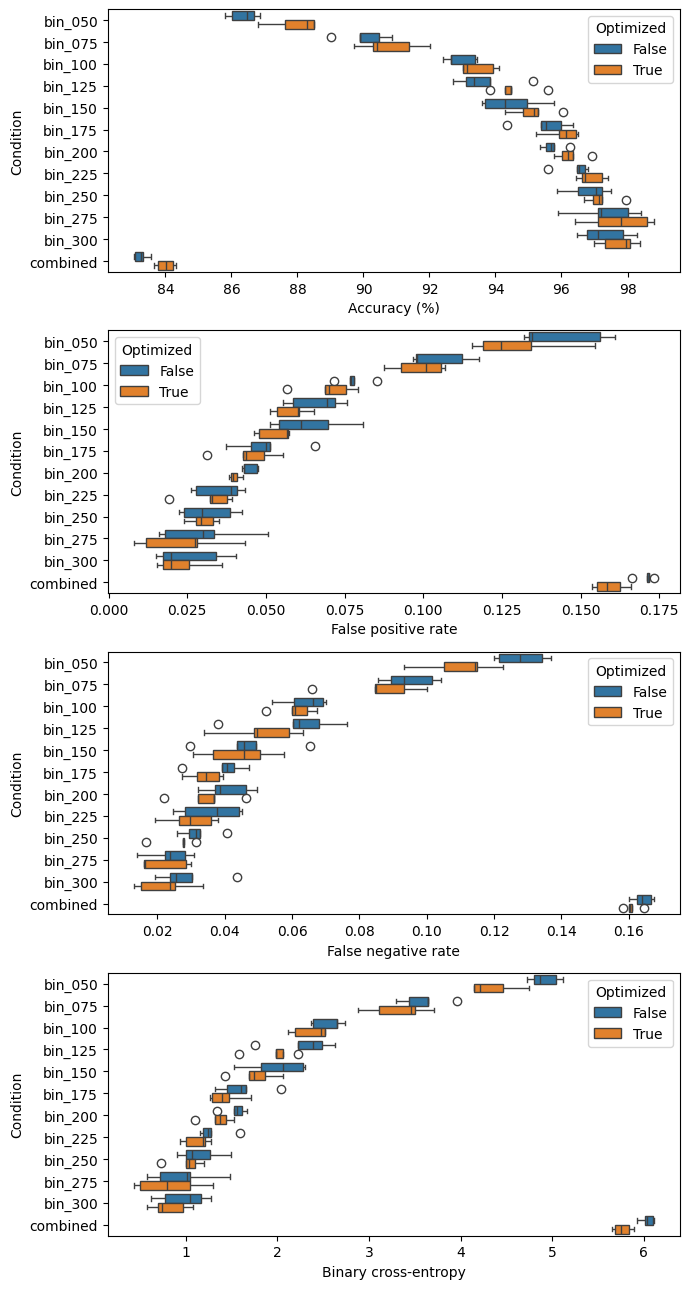

In [10]:
# First we need to go through the hyperparameter optimization results and get
# them formatted so we can add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()

Doesn't seem like the hyperparameter optimization gained us much ground. We did specify a pretty high-dimensional parameter space. Let's do a big, long run with lots of iterations overnight tonight.

### 3.4. Winning models evaluation on hold-out test data

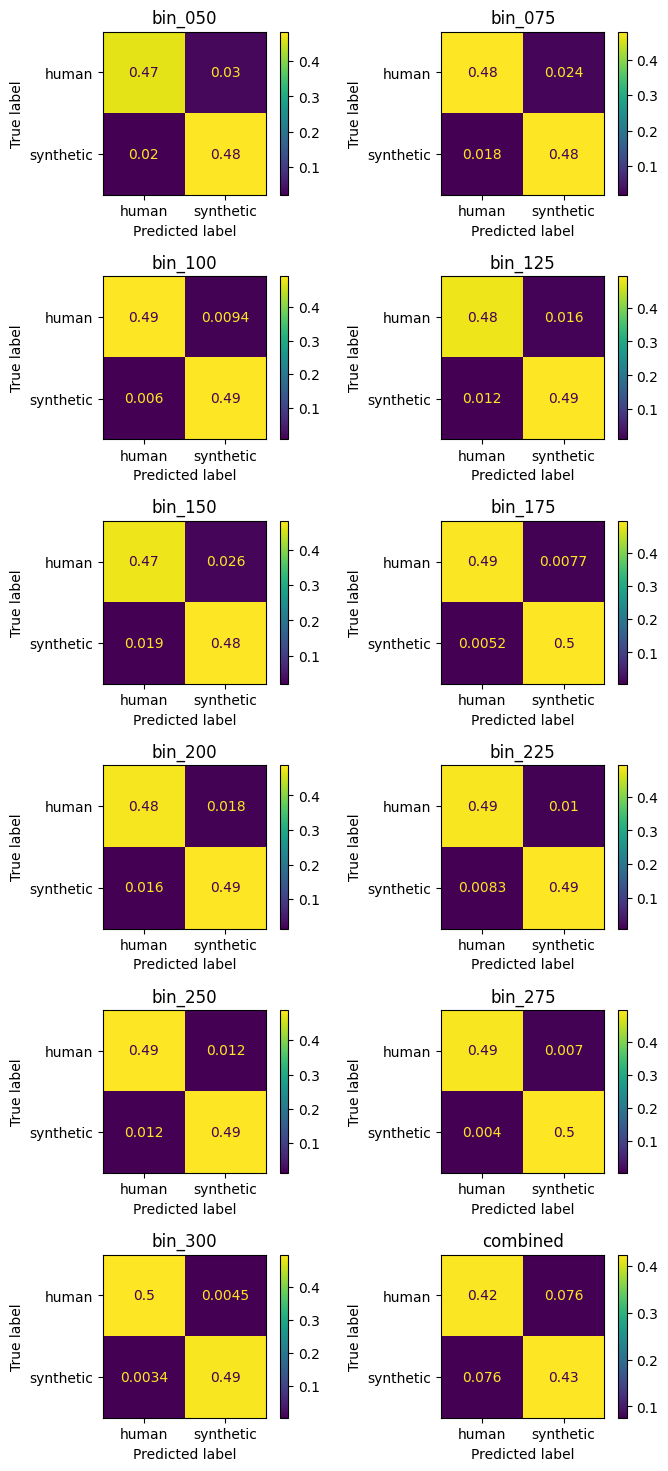

In [11]:
# Plot confusion matrix for hold-out test data in each bin
plot_funcs.plot_testing_confusion_matrices(winners, input_file).show()

Wow, looks great! Performance on the test data is as good as or better than expected from cross-validation.

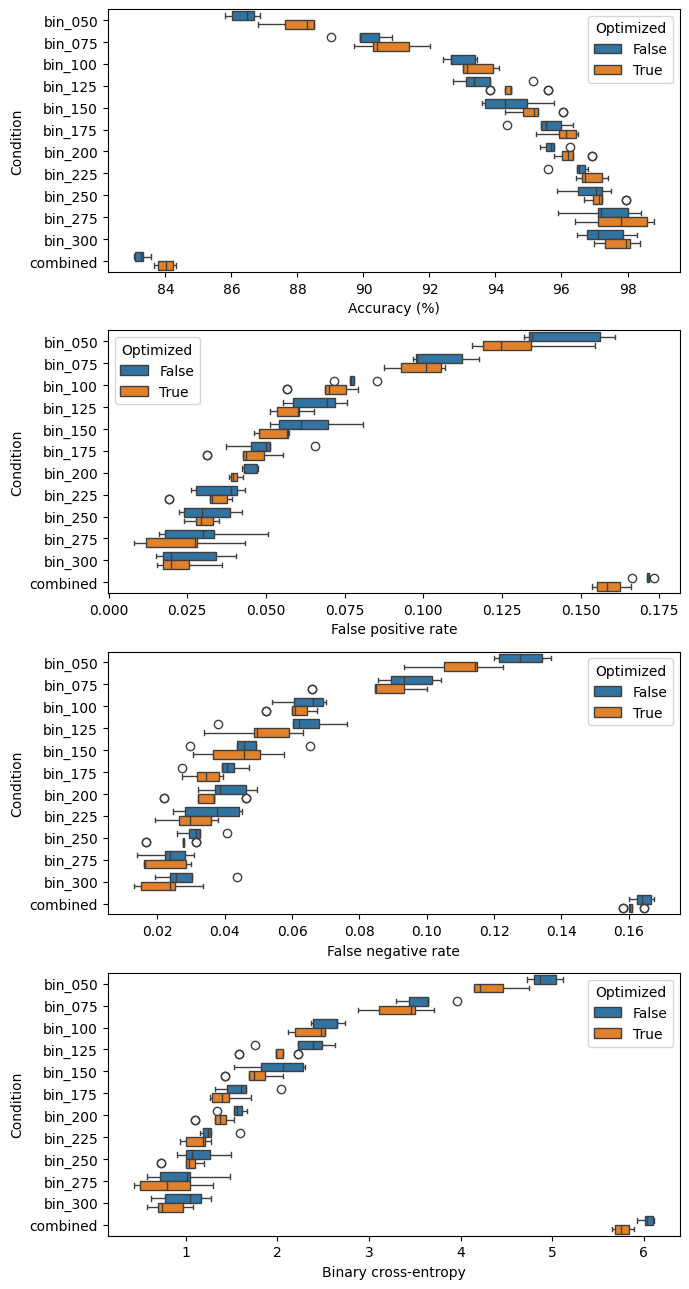

In [12]:
# First we need to go through the hyperparameter optimization results and get
# them formatted so we can add them to the results from the baseline cross-validation
parsed_results = xgb_funcs.add_winners_to_parsed_results(
    cv_results, 
    parsed_results, 
    cv_folds
)

plot_funcs.plot_two_factor_cross_validation(plots, parsed_results).show()